In [1]:
from __future__ import print_function
from ctypes import CFUNCTYPE, c_double
import llvmlite.binding as llvm
import ast
import astor 
import showast
import codegen
from numba import jit
import sys
import re
import os
from pprint import pprint
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'


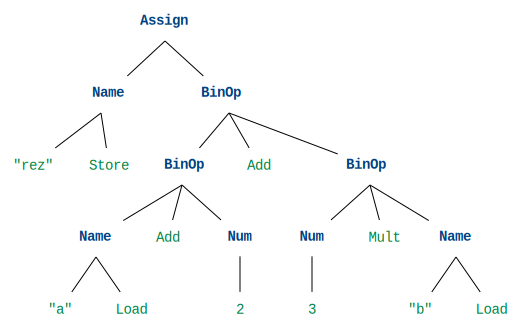

In [2]:
%%showast
rez = a+2+3*b

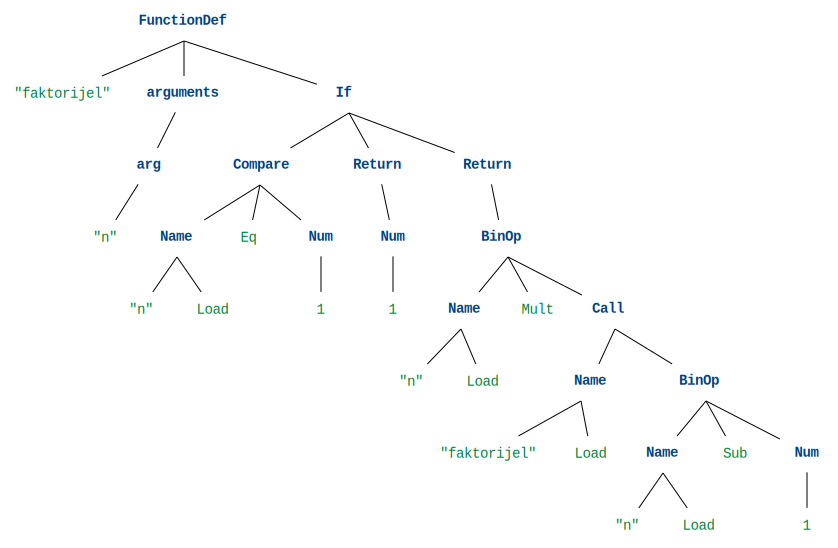

In [3]:
%%showast
def faktorijel(n):
    if(n == 1):
        return 1
    else:
        return n * faktorijel(n - 1)

In [4]:
#Od strane 3: http://poincare.matf.bg.ac.rs/~jelenagr/rs2/DP5.pdf

class Node:
    pass

class UnaryOperator(Node):
    def __init__(self, operand):
        self.operand = operand

class BinaryOperator(Node):
    def __init__(self, left, right):
        self.left = left
        self.right = right

class Add(BinaryOperator):
    pass

class Sub(BinaryOperator):
    pass

class Mul(BinaryOperator):
    pass

class Div(BinaryOperator):
    pass

class Negate(UnaryOperator):
    pass

class Number(Node):
    def __init__(self, value):
        self.value = value
class NodeVisitor:
    def visit(self, node, way):
        methname = 'visit_' + type(node).__name__ + '_'+ way
       
        meth = getattr(self, methname, None)
        if meth is None:
            meth = self.generic_visit
    
        return meth(node)

    def generic_visit(self, node):
        raise RuntimeError('No {} method'.format('visit_' + type(node).__name__))

class StackCode(NodeVisitor):
    
    def __init__(self, way):
        self.way = way
    
    def generate_code(self, node):
        self.instructions = []
        self.visit(node, self.way)
        return self.instructions

    def visit_Number_postfix(self, node):
        self.instructions.append(('PUSH', node.value))

    def visit_Add_postfix(self, node):
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        self.instructions.append(('ADD',))

    def visit_Sub_postfix(self, node):
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        self.instructions.append(('SUB',))

    def visit_Mul_postfix(self, node):
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        self.instructions.append(('MUL',))

    def visit_Div_postfix(self, node):
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        self.instructions.append(('DIV',))

    def visit_Negate_postfix(self, node):
        self.visit(node.operand, self.way)
        self.instructions.append(('NEG',))
     
    def visit_Number_postfix(self, node):
        self.instructions.append(('PUSH', node.value))

    def visit_Add_infix(self, node):
        self.visit(node.left, self.way)
        self.instructions.append(('ADD',))
        self.visit(node.right, self.way)
        
    def visit_Sub_infix(self, node):
        self.visit(node.left, self.way)
        self.instructions.append(('SUB',))
        self.visit(node.right, self.way)
        

    def visit_Mul_infix(self, node):
        self.visit(node.left, self.way)
        self.instructions.append(('MUL',))
        self.visit(node.right, self.way)

    def visit_Div_infix(self, node):
        self.visit(node.left, self.way)
        self.instructions.append(('DIV',))
        self.visit(node.right, self.way)
        

    def visit_Negate_infix(self, node):
        self.visit(node.operand, self.way)
        self.instructions.append(('NEG',))
        
    def visit_Number_infix(self, node):
        self.instructions.append(('PUSH', node.value))
        

    def visit_Add_prefix(self, node):
        self.instructions.append(('ADD',))
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        
    def visit_Sub_prefix(self, node):
        self.instructions.append(('SUB',))
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        

    def visit_Mul_prefix(self, node):
        self.instructions.append(('MUL',))
        self.visit(node.left, self.way) 
        self.visit(node.right, self.way)

    def visit_Div_prefix(self, node):
        self.instructions.append(('DIV',))
        self.visit(node.left, self.way)
        self.visit(node.right, self.way)
        

    def visit_Negate_prefix(self, node):
        self.instructions.append(('NEG',))
        self.visit(node.operand, self.way)
        
    def visit_Number_prefix(self, node):
        self.instructions.append(('PUSH', node.value))
        
t1 = Sub(Number(3), Number(4))
t2 = Mul(Number(2), t1)
t3 = Div(t2, Number(5))
t4 = Add(Number(1), t3)
print("ispisujemo infiksno Levo -> Koren -> Desno")
s = StackCode("infix")
code = s.generate_code(t2)
for c in code:
    print(c)
    
print("\n\n Ispisujemo postfiksno Levo -> Desno -> Koren")
s = StackCode("postfix")
code = s.generate_code(t2)
for c in code:
    print(c)


print("\n\n Ispisujemo prefiksno Koren -> Levo -> Desno")
s = StackCode("prefix")
code = s.generate_code(t2)
for c in code:
    print(c)

    
    


ispisujemo infiksno Levo -> Koren -> Desno
('PUSH', 2)
('MUL',)
('PUSH', 3)
('SUB',)
('PUSH', 4)


 Ispisujemo postfiksno Levo -> Desno -> Koren
('PUSH', 2)
('PUSH', 3)
('PUSH', 4)
('SUB',)
('MUL',)


 Ispisujemo prefiksno Koren -> Levo -> Desno
('MUL',)
('PUSH', 2)
('SUB',)
('PUSH', 3)
('PUSH', 4)


In [5]:
import ast

def dump(obj):
    for attr in dir(obj):
        print("obj.%s = %r" % (attr, getattr(obj, attr)))

try:
    with open("fajl.txt", "r") as f:
        data = f.read()
except IOError:
    sys.exit("Nije uspeo da otvori fajl")

p = ast.parse(data)
print("Module object ==> {}".format(p))
exec(compile(p, filename="<ast>", mode="exec"))



Module object ==> <_ast.Module object at 0x0000015A407F6AC8>
Zdravo svete!
i ovo moze


In [35]:
from llvmlite import ir
import ast
from collections import deque 
import sys, re, os



class ast_parse_llvmir:
    
    def __init__(self):
        self.vars = {}
        self.fn = []
        self.builders = []
        self.builder = None
        self.lista = []

    
    def mapiraj(self, op):
        mapa = {
            'LtE': '<=',
            'Lt': '<',
            'GtE': '>=',
            'Gt': '>',
            'Eq': '==',
            'NotEq': '!='
        }
        if(op in mapa):
            return mapa[op]
        else:
            return None
        


    def callFun(self, node):
        num_of_vars = len(node.args.args) 
        m = ir.Module()
        list = []
        for i in range(num_of_vars):
            list.append(ir.IntType(32))
        fnty = ir.FunctionType(ir.IntType(32) , list)
        fn = ir.Function(m, fnty,  node.name)
        self.fn.append(fn)
        builder = ir.IRBuilder(fn.append_basic_block('entry'))
        for i in range(num_of_vars):
            fn.args[i].name= node.args.args[i].arg
            print(fn.args[i])
            a = builder.alloca(ir.IntType(32), name= fn.args[i].name)
            self.vars[node.args.args[i].arg] = a
        self.builders.append(builder)
        
        for i in range(len(node.body)):
            self.ast_visit(node.body[i])
      
        self.fn.pop(-1)
        self.builders.pop(-1)
        print(fn, end ="")
        if(len(self.fn) == 0):
            return -1
        else:
            return 0
        
    def findOperators(self, node):
        try:
            left = node.test.left.n
            
        except AttributeError:
            left = node.test.left.id
        try:
            right = node.test.comparators[0].id
        except AttributeError:
            right = node.test.comparators[0].n
            
        return (left, right)

        
    def pripadaNekom(self, operand):
        if(operand in self.vars):
            return self.vars[operand]
        elif(operand in fn.args):
            for i in fn.args:
                if operand == fn.args[i]:
                    return fn.args[i]
        else:
            return -1

    def callIf(self, node):
        #OVDE UBACUJEM OPERATORE U LEFT I RIGHT
        (left, right) = self.findOperators(node)
        
        #iz liste ubacujem u lokalnu varijablu da bi IF znao kojoj f-ji pripada
        fn = self.fn[-1]
        
        ifhead = fn.append_basic_block('if.header')
        ifbody = fn.append_basic_block('if.body')
        builder = self.builders[-1]

        builder.branch(ifhead)
        builder.position_at_end(ifhead)
        
        #ovde dohvatam operator ako ga prepoznajem, ako ne vraca -1
        op = (self.mapiraj(node.test.ops[0].__class__.__name__))
        if(op is None):
            print("Pogresio si operator")
            return -1
        
        #U ovom bloku se proveravaju left i right, odnosno da li su konstante ili varijable
        if(isinstance(left, int) or left.isdigit()):
            left = ir.Constant(ir.DoubleType(), float(left))
        else:
            left = self.pripadaNekom(left)
            if left == -1:
                print("levi operand nije ni konstanta ni varijabla")
                return -1
        if(isinstance(right, int) or right.isdigit()):
            right = ir.Constant(ir.DoubleType(), float(right))
        else:
            right = self.pripadaNekom(right)
            if right == -1:
                print("Desni operand nije ni konstanta ni varijabla")
                return -1
        
        
        #ovde se upisuje Zaglavlje IF-a
        pred = builder.icmp_signed(op, left, right)

        #prelazimo na Body
        builder.position_at_end(ifbody)
        returnValue = node.body[0].value.n
        returNValue = ir.Constant(ir.DoubleType(), float(returnValue))
        builder.ret(fn.args[0])


        
        return 0
        
        
    def create_tree(self, node):
        if((hasattr(node, 'right') == False) and (hasattr(node, 'left') == False)):
            if(hasattr(node, 'n')):
                atribut = node.n
            else:
                atribut = node.id
            self.lista.append(atribut)
        
        if(hasattr(node, 'op') == True):
            root = node.op.__class__.__name__
            self.lista.append(root)


        if(hasattr(node, 'left') == True):
            self.create_tree(node.left)

        if(hasattr(node, 'right') == True):
            self.create_tree(node.right)

    
    def izListeUString(self):
        brojacB = 0
        brojacZatvorenih = 0
        brojacOp = 0
        tmp = ""
        for i in range(len(self.lista)):
            if(self.lista[i] == 'Add'):
                brojacB = 0
                brojacOp += 1
                tmp += "builder.add("
            elif(self.lista[i] == 'Mult'):
                tmp += '\n'
                tmp+= "builder.mul("
                brojacB = 0
                brojacOp += 1
            else:
                broj = str(self.lista[i])
                brojacB += 1
                if(isinstance(self.lista[i], int)):
                    tmp+= ("ir.Constant(ir.IntType(32), " + broj + ")")
                elif(self.lista[i] in self.vars):
                    var = self.vars[self.lista[i]]
                    print(str(var))
                    tmp+= "builder.load(var)"

                else:
                    print("GRESKA, koristis promenjivu u dodeli koja nije prethodno inicijalizovana: {}".format(self.lista[i]))
                    
                    return -1
                if(brojacB%2 == 1):
                    tmp += ', '
                    
                if(isinstance(self.lista[i-1], int) or self.lista[i-1] in self.vars):
                    tmp += ') '
                    brojacOp -= 1
                    if(brojacOp > 0):
                        tmp += ') '
                        brojacOp -= 1
                        if(brojacOp > 0):
                            tmp += ', '
            
        print(tmp)                    
        return tmp
                

        
    def callAssign(self, node):
        self.create_tree(node.value)
        
        tmp = """builder.store("""

        if(self.izListeUString() != -1):
            tmp += self.izListeUString()
        else:
            return -1
        p = node.targets[0].id
        builder = self.builders[-1]
        print(self.lista)
        self.lista = []
        promenjiva = builder.alloca(ir.IntType(32), name= p)
        tmp += ', ' + 'promenjiva' + ')'
        #print(tmp)
        exec(tmp)
       
        self.vars[p] = promenjiva
        
        

    def callReturn(self, node):
        builder = self.builders[-1]
        self.create_tree(node.value)
        tmp = """builder.ret("""
        if(self.izListeUString() != -1):
            tmp += self.izListeUString()
        else:
            return -1
        tmp += ')'
        exec(tmp)
        

    def str_node(self, node):
        if isinstance(node, ast.AST):
            fields = [(name, self.str_node(val)) for name, val in ast.iter_fields(node) if name not in ('left', 'right')]
            if(node.__class__.__name__ == 'FunctionDef'):
          
                provera = self.callFun(node)
                if(provera == -1):
                    return -1
            elif(node.__class__.__name__ == 'If'):
                provera = self.callIf(node)
                if(provera == -1):
                    return -1
                
            elif(node.__class__.__name__ == "Assign"):
                provera = self.callAssign(node)
                if(provera == -1):
                    return -1
                pass
            elif(node.__class__.__name__ == "Return"):
                self.callReturn(node)
            else:
                rv = '%s(%s' % (node.__class__.__name__, ', '.join('%s=%s' % field for field in fields))
                #print(rv)
        else:
            return 0
    def ast_visit(self, node):
        provera = self.str_node(node)
        if(provera == -1):
            return -1
        for field, value in ast.iter_fields(node):
            if isinstance(value, list):
                for item in value:
                    if isinstance(item, ast.AST):
                        self.ast_visit(item)
            elif isinstance(value, ast.AST):
                self.ast_visit(value)


string = """
def f(n):
    m = 10
    p = 24
    if((m*12 > 14) and (p == 15+10)):
        return 1

"""

parsiran = ast.parse(string)

g = ast_parse_llvmir()
g.ast_visit(parsiran) 



i32 %"n"
ir.Constant(ir.IntType(32), 10), ) 
ir.Constant(ir.IntType(32), 10), ) 
[10]


SyntaxError: invalid syntax (<string>, line 1)

In [20]:
# llvm => https://www.rt-rk.uns.ac.rs/sites/default/files/Aleksandar%20Beserminji,%20master%20rad.pdf
# ovo moze da bude nesto dobro: https://llvmlite.readthedocs.io/en/latest/user-guide/binding/examples.html
import llvmlite.binding as llvm
from ctypes import CFUNCTYPE
import cs50
import math
from prestans import types
import ctypes



llvm.initialize()
llvm.initialize_native_target()
llvm.initialize_native_asmprinter()  # yes, even this one

llvm_ir1 = """
   ; ModuleID = "examples/ir_fpadd.py"
   target triple = "unknown-unknown-unknown"
   target datalayout = ""

   define double @"fpadd"(double %".1", double %".2")
   {
   entry:
     %"res" = fadd double %".1", %".2"
     ret double %"res"
   }
   """

llvm_ir = """
   ; ModuleID = "examples/ir_fpadd.py"
   target triple = "unknown-unknown-unknown"
   target datalayout = ""

define i32 @"f"(i32 %"n") 
{
entry:
  %"n.1" = alloca i32
  %".3" = mul i32 2, 5
  ret i32 %".3"
}
   """


def create_execution_engine():
    """
    Create an ExecutionEngine suitable for JIT code generation on
    the host CPU.  The engine is reusable for an arbitrary number of
    modules.
    """
    # Create a target machine representing the host
    target = llvm.Target.from_default_triple()
    target_machine = target.create_target_machine()
    # And an execution engine with an empty backing module
    backing_mod = llvm.parse_assembly("")
    engine = llvm.create_mcjit_compiler(backing_mod, target_machine)
    return engine


def compile_ir(engine, llvm_ir):
    """
    Compile the LLVM IR string with the given engine.
    The compiled module object is returned.
    """
    # Create a LLVM module object from the IR
    mod = llvm.parse_assembly(llvm_ir)
    mod.verify()
    # Now add the module and make sure it is ready for execution
    engine.add_module(mod)
    engine.finalize_object()
    engine.run_static_constructors()
    return mod


engine = create_execution_engine()
mod = compile_ir(engine, llvm_ir)
print(mod)

# Look up the function pointer (a Python int)
func_ptr = engine.get_function_address("f")

# Run the function via ctypes
c_integer = types.Integer()
cfunc = CFUNCTYPE(ctypes.c_int32) (func_ptr)
res = cfunc(10)
print("f(1) =", res)

; ModuleID = '<string>'
source_filename = "<string>"
target datalayout = "e-m:e-i64:64-f80:128-n8:16:32:64-S128"
target triple = "unknown-unknown-unknown"

define i32 @f(i32 %n) {
entry:
  %n.1 = alloca i32
  %.3 = mul i32 2, 5
  ret i32 %.3
}

f(1) = 10


In [52]:
import ast
def str_node(node):
    if isinstance(node, ast.AST):
        fields = [(name, str_node(val)) for name, val in ast.iter_fields(node) if name not in ('left', 'right')]
        rv = '%s(%s' % (node.__class__.__name__, ', '.join('%s=%s' % field for field in fields))
        return rv + ')'
    else:
        return repr(node)
def ast_visit(node, level=0):
    print('  ' * level + str_node(node))
    for field, value in ast.iter_fields(node):
        if isinstance(value, list):
            for item in value:
                if isinstance(item, ast.AST):
                    print("jos jedan")
                    ast_visit(item, level=level+1)
                    
        elif isinstance(value, ast.AST):
            print("jos jedan")
            ast_visit(value, level=level+1)
            
            

str = """
def faktorijel(n, p, k):
    if(n+2 -p > k):
        return 1
    else:
        return n * faktorijel(n - 1)
"""


ast_visit(ast.parse(str))

Module(body=[<_ast.FunctionDef object at 0x0000015A40CA39B0>])
jos jedan
  FunctionDef(name='faktorijel', args=arguments(args=[<_ast.arg object at 0x0000015A40D320F0>, <_ast.arg object at 0x0000015A40D327B8>, <_ast.arg object at 0x0000015A40D325C0>], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]), body=[<_ast.If object at 0x0000015A40D326D8>], decorator_list=[], returns=None)
jos jedan
    arguments(args=[<_ast.arg object at 0x0000015A40D320F0>, <_ast.arg object at 0x0000015A40D327B8>, <_ast.arg object at 0x0000015A40D325C0>], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[])
jos jedan
      arg(arg='n', annotation=None)
jos jedan
      arg(arg='p', annotation=None)
jos jedan
      arg(arg='k', annotation=None)
jos jedan
    If(test=Compare(ops=[<_ast.Gt object at 0x0000015A2E400048>], comparators=[<_ast.Name object at 0x0000015A40D32710>]), body=[<_ast.Return object at 0x0000015A40D32390>], orelse=[<_ast.Return object at 0x0000015A40D32320>])
j

In [ ]:
class FuncVisitor(ast.NodeVisitor):
    def __init__(self):
        self.vars = {}
        self.func = []
        self.builder = None

    def parse_children(self, parent, item):
        """
        recursive function for parsing elements
        Args:
            item: current element to parse
            parent: its parent

        Returns:

        """
        # parse only functions and classes
        if not isinstance(item, (ast.FunctionDef, ast.ClassDef)):
            return
        else:

            new_item = _create_item(item)

            add_to_tree(parent, new_item)
            if isinstance(item, (ast.FunctionDef, ast.ClassDef)):
                sub_components = item.body
                for comp in sub_components:
                        item = _create_item(comp)
                        if item is None:
                            continue
                        self.parse_children(new_item, comp)

    def visit_FunctionDef(self, node):
        num_of_vars = len(node.args.args) 
        m = ir.Module()
        list = []
        for i in range(num_of_vars):
            list.append(ir.IntType(32))
        fnty = ir.FunctionType(ir.IntType(32) , list)
        fn = ir.Function(m, fnty,  node.name)
        self.func.append(fn)
        for i in range(num_of_vars):
            fn.args[i].name= node.args.args[i].arg
        self.builder = ir.IRBuilder(fn.append_basic_block('entry'))
        print(fn, end ="")

    def visit_Assign(self, node):
        self.builder.store(builder.add(builder.load(out), builder.load(ct)), out)

    
    def visit_If(self, node):
        ifhead = fn.append_basic_block('if.header')
        ifbody = fn.append_basic_block('if.body')
        ifend = fn.append_basic_block('if.end')
        fn = self.func[-1]
        self.builder = ir.IRBuilder(fn.append_basic_block('if_Block'))

        self.builder.branch(ifhead)
        self.builder.position_at_end(ifhead)
        print("OKUSAVAMO SLEDECE:")
        print(fn.args[0])


        right = node.test.comparators[0].n # daje jedan
        left = (node.test.left.id) # daje n
        op = (mapiraj(node.test.ops[0].__class__.__name__))
        if(op is None):
            print("Pogresio si operator")

        if(left.isdigit()):
            left = ir.Constant(int_type, int(left));
        if(right.isdigit()):
            right = ir.Constant(int_type, int(right));

        print(fn.args[0])
        pred = builder.icmp_signed(op, left, fn.args[0])
        builder.cbranch(pred, ifbody, ifend)